In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set()

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, f_regression, SelectFromModel, RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Data load

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Column 설정

In [5]:
target = 'target'

In [6]:
columns_useless = ['id']
# columns_useless = columns_useless + ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_5']

In [7]:
columns_num_all = joblib.load('columns_num.pkl')
columns_cat_all = joblib.load('columns_cat.pkl')
columns_binary_num = joblib.load('columns_binary_num.pkl')
columns_binary_cat = joblib.load('columns_binary_cat.pkl')

In [8]:
try :
    columns_num_all.remove(target)
    
except :
    pass

In [9]:
try :
    columns_cat_all.remove(target)
    
except :
    pass

In [10]:
columns_num = []

for column in columns_num_all :
    
    if column not in columns_useless :
        columns_num.append(column)

In [11]:
columns_cat = []

for column in columns_cat_all :
    
    if column not in columns_useless :
        columns_cat.append(column)

In [12]:
columns_sc = []

for column in columns_num :
    
    if column not in columns_binary_num:
        columns_sc.append(column)
        
columns_sc

[]

In [13]:
columns_en = []

for column in columns_cat :
    
    if (column not in columns_binary_num) and (column not in columns_binary_cat):
        columns_en.append(column)
        
columns_en

['nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'nom_5',
 'nom_6',
 'nom_7',
 'nom_8',
 'nom_9',
 'ord_1',
 'ord_2',
 'ord_3',
 'ord_4',
 'ord_5',
 'ord_0',
 'day',
 'month']

# Target 분리

In [14]:
# y = data[target]
# X = data.drop(target, axis=1)

In [15]:
y_train = train[target]
X_train = train.drop(target, axis=1)
X_train_og = X_train.copy()

In [16]:
X_test = test.copy()

# 전체 dataset concat

In [17]:
all_data = pd.concat([X_train, X_test])

# Data preprocessing

In [18]:
def preprocessing(data, X_train_og, columns_useless, columns_sc, columns_binary_cat, columns_en) :
    
    # useless column 제거
    data.drop(columns_useless, axis=1, inplace=True)
    
    # scaling
#     scaler = StandardScaler()
#     scaler.fit(X_train_og[columns_sc])
#     data[columns_sc] = scaler.transform(data[columns_sc])

    # binary data 처리
    column = columns_binary_cat[0]
    index_1 = data[data[column] == 'T'].index
    index_0 = data[data[column] == 'F'].index
    data.loc[index_1, column] = 1
    data.loc[index_0, column] = 0
    
    column = columns_binary_cat[1]
    index_1 = data[data[column] == 'Y'].index
    index_0 = data[data[column] == 'N'].index
    data.loc[index_1, column] = 1
    data.loc[index_0, column] = 0
    
    data[columns_binary_cat] = data[columns_binary_cat].astype('int64')
    
    # One-hot-encoding
#     data = pd.get_dummies(data, columns=columns_en)
    encoder = OneHotEncoder()   # 고윳값을 많이 가진 feature가 있는 경우는 OneHotEncoder를 사용해야 함
    data = encoder.fit_transform(data)
    
    return data

In [19]:
all_data = preprocessing(all_data, X_train_og, columns_useless, columns_sc, columns_binary_cat, columns_en)

# Train & test set 분리

In [20]:
X_train = all_data[:len(train)]
X_test = all_data[len(train):]

# Grid search

In [21]:
logit = LogisticRegression(C=1.0, random_state=30)

In [22]:
pipe = Pipeline([
    ('select', SelectPercentile(score_func=f_classif, percentile=30)),
    ('model', logit)
])

In [23]:
param_grid = {
    'select__percentile' : [20, 40, 60, 80, 100],
    'model__C': np.logspace(-3, 2, 6)
}

In [24]:
grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('select',
                                        SelectPercentile(percentile=30)),
                                       ('model',
                                        LogisticRegression(random_state=30))]),
             param_grid={'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'select__percentile': [20, 40, 60, 80, 100]},
             return_train_score=True)

In [25]:
results = pd.DataFrame(grid.cv_results_)
results = results[['params', 'mean_test_score', 'mean_train_score', 'mean_fit_time', 'mean_score_time']]
display(results)

,params,mean_test_score,mean_train_score,mean_fit_time,mean_score_time
0,"{'model__C': 0.001, 'select__percentile': 20}",0.738387,0.739240,2.325844,0.030799
1,"{'model__C': 0.001, 'select__percentile': 40}",0.738550,0.739389,2.255721,0.027420
2,"{'model__C': 0.001, 'select__percentile': 60}",0.738567,0.739506,2.570178,0.029130
3,"{'model__C': 0.001, 'select__percentile': 80}",0.738610,0.739527,2.532275,0.026323
4,"{'model__C': 0.001, 'select__percentile': 100}",0.738667,0.739588,2.423401,0.025324
5,"{'model__C': 0.01, 'select__percentile': 20}",0.755497,0.759210,4.406376,0.023739
6,"{'model__C': 0.01, 'select__percentile': 40}",0.756583,0.760500,5.641738,0.032121
7,"{'model__C': 0.01, 'select__percentile': 60}",0.756667,0.761112,5.479604,0.026529
8,"{'model__C': 0.01, 'select__percentile': 80}",0.757023,0.761448,5.620861,0.032901
9,"{'model__C': 0.01, 'select__percentile': 100}",0.756983,0.761539,6.217647,0.030375


Text(169.68000000000006, 0.5, 'model__C')

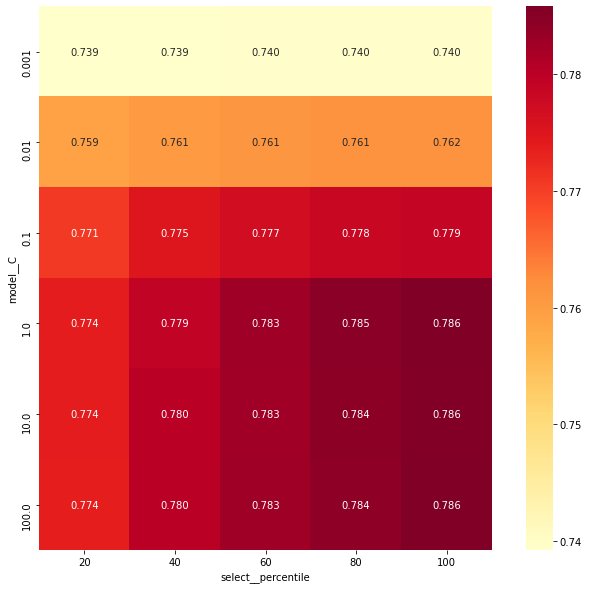

In [26]:
score = np.array(results.mean_train_score).reshape(len(list(param_grid.values())[1]), len(list(param_grid.values())[0]))

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(score, xticklabels=list(param_grid.values())[0], yticklabels=list(param_grid.values())[1], 
            annot=True, fmt='.3f', square=True, cbar=True, cmap='YlOrRd')

plt.xlabel(list(param_grid.keys())[0])
plt.ylabel(list(param_grid.keys())[1])

Text(169.68000000000006, 0.5, 'model__C')

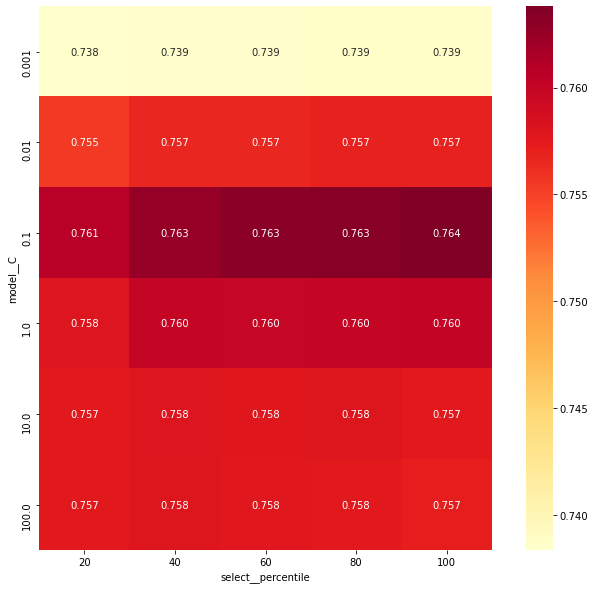

In [27]:
score = np.array(results.mean_test_score).reshape(len(list(param_grid.values())[1]), len(list(param_grid.values())[0]))

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(score, xticklabels=list(param_grid.values())[0], yticklabels=list(param_grid.values())[1], 
            annot=True, fmt='.3f', square=True, cbar=True, cmap='YlOrRd')

plt.xlabel(list(param_grid.keys())[0])
plt.ylabel(list(param_grid.keys())[1])

In [28]:
print('best hyperpameter : \n{}' .format(grid.best_params_), '\n')
print("best score : {:.3f}".format(grid.best_score_))

best hyperpameter : 
{'model__C': 0.1, 'select__percentile': 100} 

best score : 0.764
